**Data Preparation**

In [12]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Assuming historical_data is a DataFrame containing the historical market data
historical_data = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/Portfolio Hedging using Generative Adversarial Networks (GANs)/marketdata.csv')

# Exclude the 'Date' column
historical_data_values = historical_data.drop(columns=['Date']).values

class MarketDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

market_dataset = MarketDataset(historical_data_values)
data_loader = DataLoader(market_dataset, batch_size=32, shuffle=True)


**Define GAN Components**

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


**Train the GAN**

In [14]:
def train_gan(generator, discriminator, data_loader, num_epochs=1000, latent_dim=100, lr=0.0002):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for real_data in data_loader:
            batch_size = real_data.size(0)

            # Train Discriminator
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

latent_dim = 100
input_dim = historical_data_values.shape[1]
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

train_gan(generator, discriminator, data_loader, num_epochs=1000, latent_dim=latent_dim)


Epoch [0/1000], d_loss: 0.507274866104126, g_loss: 0.9341040849685669
Epoch [100/1000], d_loss: 2.2271255147643387e-05, g_loss: 10.715970993041992
Epoch [200/1000], d_loss: 1.2087551795048057e-06, g_loss: 13.630061149597168
Epoch [300/1000], d_loss: 8.635486636876522e-08, g_loss: 16.265533447265625
Epoch [400/1000], d_loss: 6.595872292791682e-09, g_loss: 18.837549209594727
Epoch [500/1000], d_loss: 6.861831658433459e-10, g_loss: 21.10048484802246
Epoch [600/1000], d_loss: 9.804777822974842e-11, g_loss: 23.04599380493164
Epoch [700/1000], d_loss: 2.500348018907861e-11, g_loss: 24.412275314331055
Epoch [800/1000], d_loss: 9.998950452339006e-12, g_loss: 25.328685760498047
Epoch [900/1000], d_loss: 6.012485214562657e-12, g_loss: 25.83725929260254


**Develop Hedging Strategies**

Generate New Market Scenarios

In [15]:
def generate_market_scenarios(generator, num_scenarios, latent_dim=100):
    z = torch.randn(num_scenarios, latent_dim)
    generated_data = generator(z).detach().numpy()
    return generated_data

num_scenarios = 1000
generated_scenarios = generate_market_scenarios(generator, num_scenarios, latent_dim)


Develop Hedging Strategies

In [16]:
def hedge_strategy(scenarios):
    # Example strategy: simple delta hedging based on generated scenarios
    deltas = scenarios[:, 0]  # Assuming first column is the delta
    hedge_positions = -deltas * num_option_contracts
    return hedge_positions

num_option_contracts = 10
hedge_positions = hedge_strategy(generated_scenarios)


**Evaluate Robustness of Strategies**

Out-of-Sample Testing

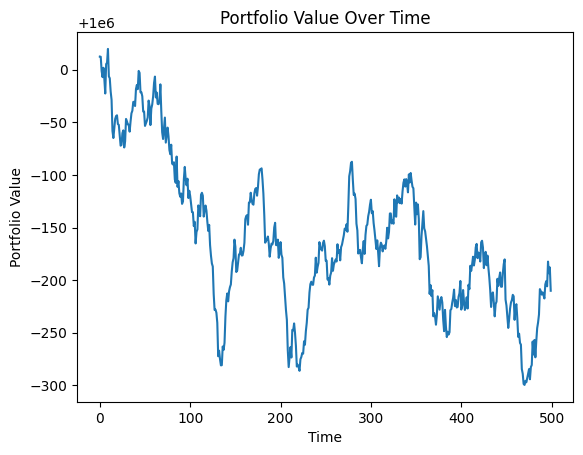

In [20]:
out_of_sample_market_data= pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/Portfolio Hedging using Generative Adversarial Networks (GANs)/outofsamplemarketdata.csv')

out_of_sample_data = out_of_sample_market_data.drop(columns=['Date']).values
out_of_sample_dataset = MarketDataset(out_of_sample_data)
out_of_sample_loader = DataLoader(out_of_sample_dataset, batch_size=1, shuffle=False)

def evaluate_strategy(generator, hedge_positions, out_of_sample_loader):
    portfolio_values = []
    initial_portfolio_value = 1000000  # Example initial portfolio value

    for i, real_data in enumerate(out_of_sample_loader):
        if i >= len(hedge_positions):
            break

        hedge_position = hedge_positions[i]
        market_change = real_data[0, 0].item() - 100  # Example market change calculation
        portfolio_value = initial_portfolio_value + hedge_position * market_change
        portfolio_values.append(portfolio_value)

    return portfolio_values

portfolio_values = evaluate_strategy(generator, hedge_positions, out_of_sample_loader)

# Visualization
import matplotlib.pyplot as plt

plt.plot(portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()
